In [59]:
import numpy as np 
import pandas as pd
import networkx as nx 
import matplotlib.pyplot as plt
from bisect import bisect_left
import random
from cdlib import algorithms
from gensim.models.word2vec import Word2Vec
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from node2vec import Node2Vec
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import coverage_error
from sklearn.metrics.pairwise import cosine_similarity
# from networkx.algorithms.community.quality import modularity, conductance
# from sklearn.metrics import jaccard_score, adjusted_rand_score, normalized_mutual_info_score
from collections import Counter
from itertools import combinations
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GraphSAGE
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from torch_geometric.datasets import Planetoid
from sklearn.metrics import roc_curve, roc_auc_score
import csv

alpha_unicode = r"\u03B1"
alpha_character = alpha_unicode.encode('utf-8').decode('unicode_escape')

## Task 0 - Create Graphs

### Extract data from the txt files


In [2]:
path = "Cit-HepPh.txt"
path2 = "cit-HepPh-dates.txt"
data = []
with open(path, "r") as file:
    for line in file:
        values = line.strip().split()
        values[0]=int(values[0])
        values[1]=int(values[1])
        data.append(values)

data = sorted(data, key=lambda x: (x[0], x[1]))
# data is sorted

# ERROR->
check_array = np.zeros(len(data))
###########

date_published = {}
with open(path2, "r") as file:
    for line in file:
        values = line.strip().split()
        values[0]=int(values[0])
        date_published[values[0]]=values[1]

date_published = dict(sorted(date_published.items(), key=lambda item: (item[1][0:4], item[1][5:7], item[1][8:10])))
# date_published = dict(sorted(date_published.items(), key=lambda item: item[0]))
        

# date_published dictionary is sorted on the basis of the dates the papers are published


### Creating graphs from extracted data
- We create an array of graphs in which the i<sup>th</sup> graph holds all the data about the citation network from 1992 till the year **1992 + i**
- This helps us analyze how the graph is changing over the years
  
**Method**  
We add papers as nodes to the graph on the basis of the date they were published.  
After adding a paper to the network, we draw all those edges which originate from that node to other nodes (the papers the current paper has cited)

In [3]:
# Create graph year by year
G = nx.DiGraph()

G_array = []
iterator = iter(date_published.items())

# def fn(arr):
#     for ele in arr:
#         print(ele.number_of_nodes(), end=" ")
#     print()
#     for ele in arr:
#         print(ele.number_of_edges(), end=" ")
#     print()

prev_year_and_month = "-1"
curr_year_and_month = "1992-02"
x_time = []

for node, date in iterator:
    # adds a graph instance to the graph array
    curr_year_and_month = date[0:7]
    if curr_year_and_month !=prev_year_and_month:
        if prev_year_and_month!="-1":
            x_time.append(curr_year_and_month)
            print(f"Current year and month = {curr_year_and_month}")
            print(f"previous year and month = {prev_year_and_month}")
            print(f"number of nodes in G = {G.number_of_nodes()}")
            print(f"Number of edges in G = {G.number_of_edges()}")
            G_array.append(G.copy())
            print(f"size of G_array = {len(G_array)}")
            print()
    prev_year_and_month = curr_year_and_month

    # creates the next graph instance
    G.add_node(node)
    ind = bisect_left(data, [node, float('-inf')])
    for i in range(ind, len(data)):
        if data[i][0] != node:
            break
        G.add_edges_from([data[i]])
        check_array[i]=1

x_time.append(curr_year_and_month)
print(f"Current year and month = {curr_year_and_month}")
print(f"number of nodes in G = {G.number_of_nodes()}")
print(f"Number of edges in G = {G.number_of_edges()}")
G_array.append(G.copy())
print(f"size of G_array = {len(G_array)}")
print()

Current year and month = 1992-03
previous year and month = 1992-02
number of nodes in G = 2
Number of edges in G = 0
size of G_array = 1

Current year and month = 1992-04
previous year and month = 1992-03
number of nodes in G = 31
Number of edges in G = 3
size of G_array = 2

Current year and month = 1992-05
previous year and month = 1992-04
number of nodes in G = 72
Number of edges in G = 4
size of G_array = 3

Current year and month = 1992-06
previous year and month = 1992-05
number of nodes in G = 125
Number of edges in G = 7
size of G_array = 4

Current year and month = 1992-07
previous year and month = 1992-06
number of nodes in G = 202
Number of edges in G = 12
size of G_array = 5

Current year and month = 1992-08
previous year and month = 1992-07
number of nodes in G = 292
Number of edges in G = 25
size of G_array = 6

Current year and month = 1992-09
previous year and month = 1992-08
number of nodes in G = 364
Number of edges in G = 32
size of G_array = 7

Current year and mont

size of G_array = 33

Current year and month = 1994-12
previous year and month = 1994-11
number of nodes in G = 5481
Number of edges in G = 10719
size of G_array = 34

Current year and month = 1995-01
previous year and month = 1994-12
number of nodes in G = 5716
Number of edges in G = 11519
size of G_array = 35

Current year and month = 1995-02
previous year and month = 1995-01
number of nodes in G = 5960
Number of edges in G = 12490
size of G_array = 36

Current year and month = 1995-03
previous year and month = 1995-02
number of nodes in G = 6205
Number of edges in G = 13616
size of G_array = 37

Current year and month = 1995-04
previous year and month = 1995-03
number of nodes in G = 6526
Number of edges in G = 15368
size of G_array = 38

Current year and month = 1995-05
previous year and month = 1995-04
number of nodes in G = 6791
Number of edges in G = 16723
size of G_array = 39

Current year and month = 1995-06
previous year and month = 1995-05
number of nodes in G = 7068
Number 

In [4]:
# These values are useful later
G_array_yearly = G_array[::12]
x_years = []
for i in range(1992, 2003):
    x_years.append(i)
every_12th_time = x_time[::12] # used to get a clear labelling for the x-axis, otherwise the dates overlap


### Note: Some datapoints have been excluded

In [5]:
count=0
cat1 = set()
cat2 = set()
for i , check_val in enumerate(check_array):
    if check_val == 0:
        cat1.add(data[i][0])
        cat2.add(data[i][1])
        count+=1
print(f"count = {count}")
print(cat1)
print(cat2)
print(len(cat1))
# THE NODES IN THE SET cat1 ARE NOT PRESENT IN THE DATES.TXT FILE
# THEY ARE ONLY PRESENT IN THE EDGES.TXT FILE
# SO, THESE PAPERS ARE NOT BEING ADDED TO OUR GRAPH, AND NEITHER ARE THE EDGES ORIGINATING FROM THESE PAPERS

count = 74164
{301222, 301223, 301224, 301225, 211336, 301226, 301227, 301228, 301229, 301230, 211337, 212314, 301231, 301233, 301234, 301235, 211338, 212315, 301236, 301237, 301238, 301239, 301240, 211339, 212316, 301241, 302122, 301242, 301243, 301244, 301245, 212317, 301246, 301247, 301248, 301249, 301250, 211341, 212318, 301252, 301253, 301254, 301255, 211342, 212319, 301256, 301257, 301258, 301260, 211343, 301261, 205001, 205003, 205004, 205005, 212320, 205007, 205008, 205009, 205010, 205011, 205012, 205013, 205014, 205015, 205016, 205017, 301263, 205019, 205020, 205021, 205022, 205023, 205024, 205025, 205026, 205027, 205028, 205029, 205030, 205031, 205032, 205033, 205034, 205035, 205036, 205037, 205038, 205039, 205040, 205041, 205042, 205043, 205044, 205045, 205046, 205047, 205048, 205049, 205050, 205051, 205052, 205053, 205054, 205055, 205056, 205057, 205058, 205059, 205060, 205061, 205062, 205063, 205064, 205065, 205066, 205067, 205068, 205069, 205070, 205071, 205072, 205073, 2

## Task 1 - Temporal Properties

### Property 1 - Analyzing the number of papers and number of citations

#### Plotting how the number of papers and number of citation change with time

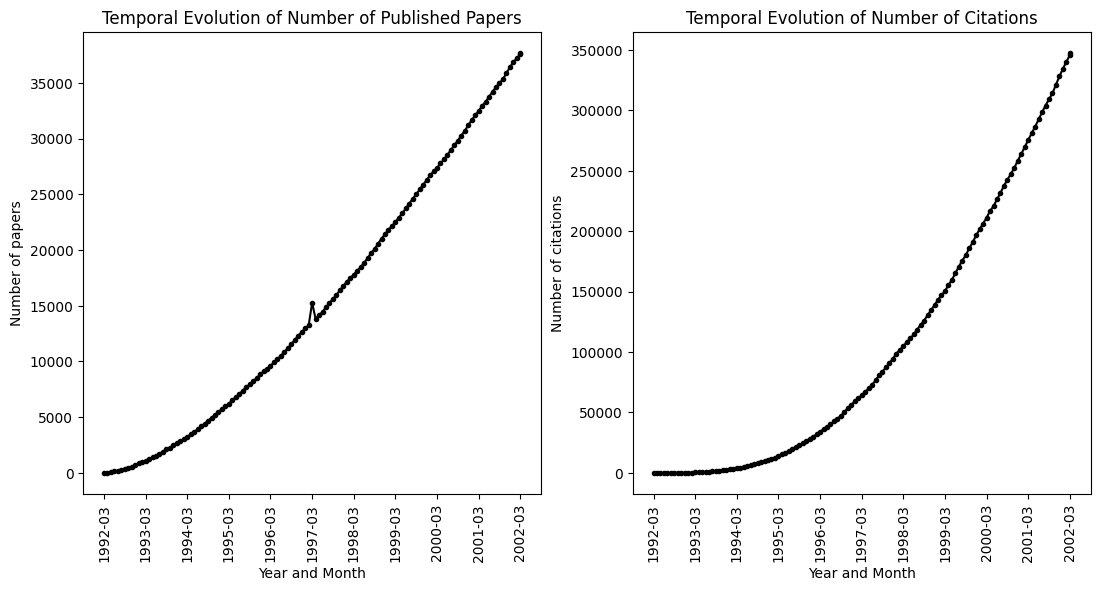

In [19]:
y_nodes = []
y_edges = []

for i, G in  enumerate(G_array):
    # print(f"num nodes = {G.number_of_nodes()}")
    y_nodes.append(G.number_of_nodes())
    y_edges.append(G.number_of_edges())


plt.figure(figsize=(13, 6))
plt.subplot(121)
plt.plot(x_time, y_nodes, linestyle="-", marker=".", label="number of papers", color="black")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.xlabel("Year and Month")
plt.ylabel("Number of papers")
plt.title("Temporal Evolution of Number of Published Papers")

plt.subplot(122)
plt.plot(x_time, y_edges, marker=".", label="number of citations", color="black")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.xlabel("Year and Month")
plt.ylabel("Number of citations")
plt.title("Temporal Evolution of Number of Citations")
plt.savefig("images/task1/property1a.png")
plt.show()

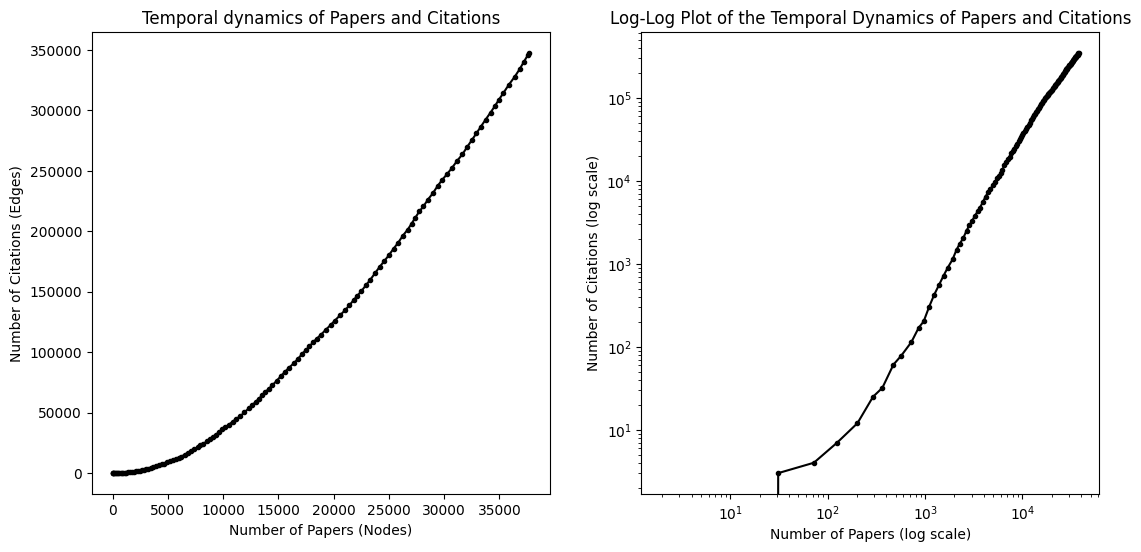

In [43]:
y_arr = []
for i, G in enumerate(G_array):
    y_arr.append(y_edges[i]/float(y_nodes[i]))

plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.plot(y_nodes, y_edges, marker=".", color="black")
plt.xlabel("Number of Papers (Nodes)")
plt.ylabel("Number of Citations (Edges)")
plt.title("Temporal dynamics of Papers and Citations")

plt.subplot(122)
plt.loglog(y_nodes, y_edges, marker=".", color="black")
plt.xlabel('Number of Papers (log scale)')
plt.ylabel('Number of Citations (log scale)')
plt.title('Log-Log Plot of the Temporal Dynamics of Papers and Citations')
plt.savefig("images/task1/property1b.png")
plt.show()

# DO SOME THINGS WITH THIS DATA
# CAN TRY OUT POLYNOMIAL REGRESSION ON IT

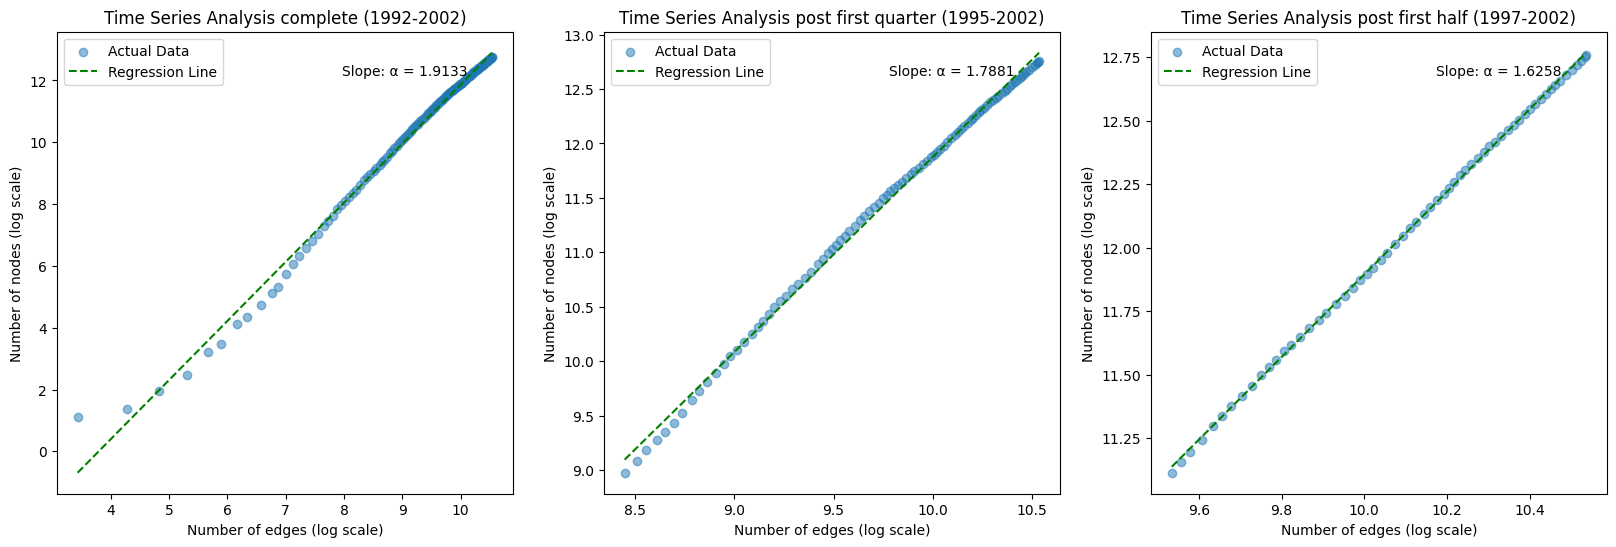

α = 1.7757


In [44]:


def calculate_alpha(y_nodes, y_edges, start_index, plt_title):

    y_nodes = y_nodes[start_index:]
    y_edges = y_edges[start_index:]
    log_y_nodes = np.log(y_nodes)
    log_y_edges = np.log(y_edges)

    X = log_y_nodes.reshape(-1, 1)
    y = log_y_edges
    model = LinearRegression()
    model.fit(X, y)

    slope = model.coef_[0]
    intercept = model.intercept_

    x_values = np.linspace(min(log_y_nodes), max(log_y_nodes), 100)
    y_values = slope * x_values + intercept

    plt.scatter(log_y_nodes, log_y_edges, label='Actual Data', alpha = 0.5)
    plt.plot(x_values, y_values, color='green', linestyle='--', label='Regression Line')
    plt.xlabel("Number of edges (log scale)")
    plt.ylabel("Number of nodes (log scale)")
    plt.title(plt_title)
    plt.text(0.9, 0.9, f'Slope: {alpha_character} = {round(slope, 4)}', ha='right', va='bottom', transform=plt.gca().transAxes)

    plt.legend()
    return slope, intercept

plt.figure(figsize=(20, 6))
plt.subplot(131)
alpha1, _ = calculate_alpha(y_nodes, y_edges, 1, "Time Series Analysis complete (1992-2002)")
plt.subplot(132)
alpha2, _ = calculate_alpha(y_nodes, y_edges, int(len(y_nodes)/4) ,"Time Series Analysis post first quarter (1995-2002)")
plt.subplot(133)
alpha3, _ = calculate_alpha(y_nodes, y_edges, int(len(y_nodes)/2) ,"Time Series Analysis post first half (1997-2002)")
plt.savefig("images/task1/property1c.png")
plt.show()


alpha = (alpha1+alpha2+alpha3)/3
print(f"{alpha_character} = {round(alpha, 4)}")


### Property 2 - Plotting the Indegrees and the Outdegrees in the graphs
The plots show the pareto-like fat-tailed distribution. 
In every row, 
1. The first plot shows how a small number of papers are cited a very high number of times, while most of the papers barely get cited.
2. The second plot shows how a small number of papers cited a lot of other papers, while most of the papers did not site many papers.

Some examples of Pareto Distribution are displayed below:

<img src="./images/pareto_distribution.png" alt="Graph Showing Pareto Distribution" width="300px" height="300px">
<img src="./images/pareto_distribution2.png" alt="Graph Showing Pareto Distribution" width="300px" height="300px">

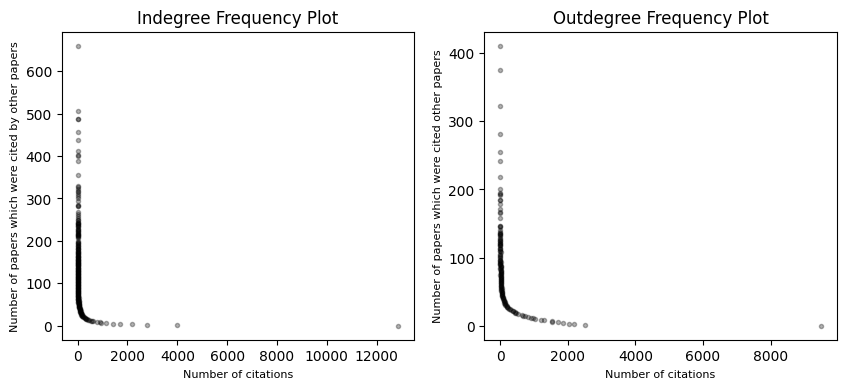

In [46]:
def plot_graph_degrees(G):
    in_degrees = dict(G.in_degree())
    out_degrees = dict(G.out_degree())

    in_degrees = dict(sorted(in_degrees.items(), key=lambda item: -item[1]))
    out_degrees = dict(sorted(out_degrees.items(), key = lambda item: -item[1]))

    def plot_function(arr, xlabel, ylabel):
        d = {}
        for e in arr:
            if e not in d:
                d[e]=1
            else:
                d[e]+=1
        x = np.array(list(d.values()))
        y = np.array(list(d.keys()))

        # messing around
        # index_of_max = np.argmax(x)
        # x = np.delete(x, index_of_max)
        # y = np.delete(y, index_of_max)
        ####
        
        plt.scatter(x=x,y=y, marker=".", alpha=0.3, color="black")
        xlab = plt.xlabel(xlabel=xlabel)
        xlab.set_fontsize(8)
        ylab = plt.ylabel(ylabel=ylabel)
        ylab.set_fontsize(8)


    in_degrees_values = np.array(list(in_degrees.values()))
    out_degrees_values = np.array(list(out_degrees.values()))

    plt.figure(figsize=(10, 4)) 
    plt.subplot(1, 2, 1) 
    plot_function(in_degrees_values, xlabel="Number of citations", ylabel="Number of papers which were cited by other papers")
    plt.title("Indegree Frequency Plot")

    plt.subplot(1, 2, 2) 
    plot_function(out_degrees_values, xlabel="Number of citations", ylabel="Number of papers which were cited other papers")
    plt.title("Outdegree Frequency Plot")
    plt.savefig("images/task1/property2.png")
    plt.show()


plot_graph_degrees(G)

### Property 3 - Density of the Graph

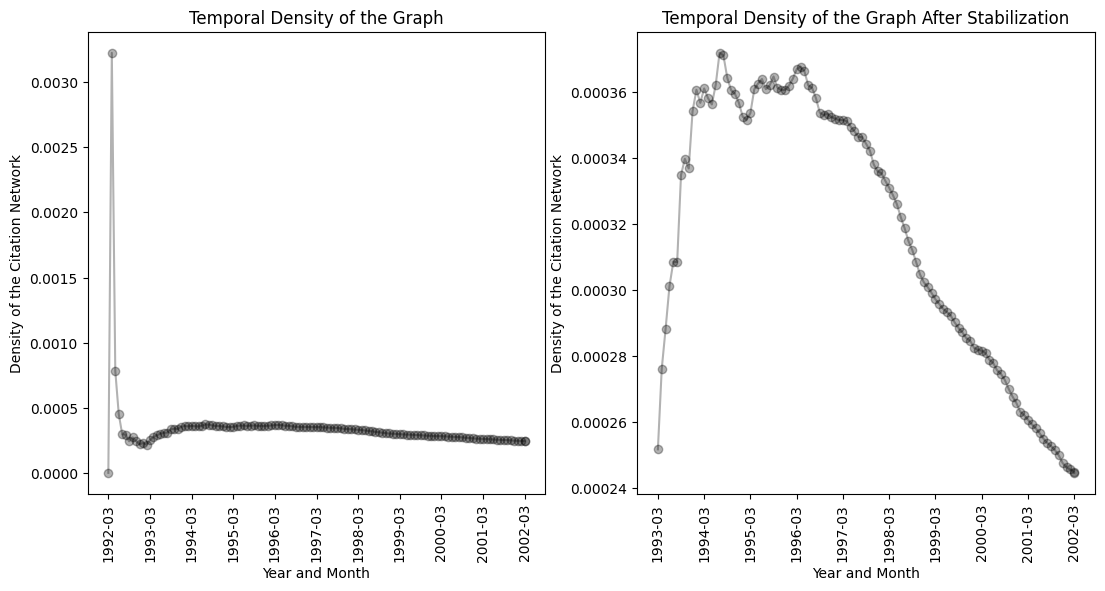

In [47]:
density_array = []
for digraph in G_array:
    density = nx.density(digraph)
    density_array.append(density)

plt.figure(figsize=(13, 6))

plt.subplot(121)
plt.plot(x_time, density_array, marker="o", color="black", alpha = 0.3)
plt.xlabel("Year and Month")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.ylabel("Density of the Citation Network")
plt.title("Temporal Density of the Graph")

plt.subplot(122)
plt.plot(x_time[12:], density_array[12:], marker="o", color="black", alpha = 0.3)
plt.xlabel("Year and Month")
plt.xticks(every_12th_time[1:], every_12th_time[1:], rotation=90)
plt.ylabel("Density of the Citation Network")
plt.title("Temporal Density of the Graph After Stabilization")
plt.savefig("images/task1/property3.png")
plt.show()

### Property 4 - Average Clustering Coefficient

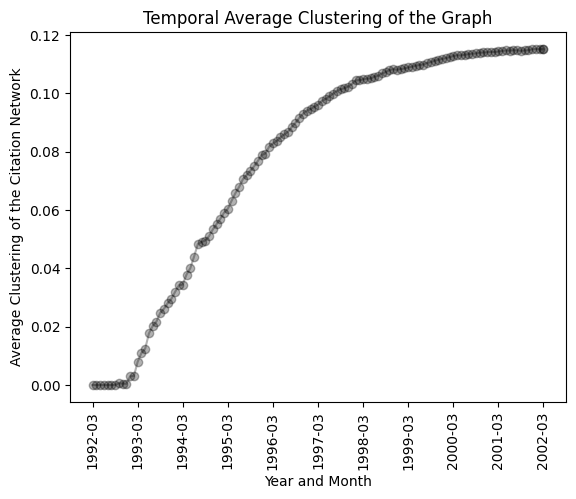

In [48]:
# TAKES 2 MINUTES TO RUN
# TIME COMPLEXITY = O(V*E)
average_clustering_array = []
for i, digraph in enumerate(G_array):
    average_clustering = nx.average_clustering(digraph)
    average_clustering_array.append(average_clustering)
    # print(f"{i}th graph has average clustering of: {average_clustering}")

plt.plot(x_time, average_clustering_array, marker="o", color="black", alpha = 0.3)
plt.xlabel("Year and Month")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.ylabel("Average Clustering of the Citation Network")
plt.title("Temporal Average Clustering of the Graph")
plt.savefig("images/task1/property4.png")
plt.show()

### Property 5 - Identifying Citation Bursts

In [51]:
# Relative Growth of Citations used over Absolute Growth
def identify_citation_bursts(G_array, threshold_percentage):
    bursts = []

    for i in range(1, len(G_array)):
        G_current = G_array[i]
        G_previous = G_array[i - 1]

        # Extracting citation data from the graphs
        edges_current = set(G_current.edges())
        edges_previous = set(G_previous.edges())

        # Find newly added citations
        new_citations = edges_current - edges_previous

        # Count new citations per paper
        citation_counts = pd.Series([target for _, target in new_citations]).value_counts()

        # Calculate the percentage increase in citations for each paper
        total_citations_previous = len(edges_previous)
        citation_percentage_increase = citation_counts / total_citations_previous * 100

        # Identify papers with citation bursts based on percentage increase
        papers_with_bursts = citation_percentage_increase[citation_percentage_increase > threshold_percentage].index.tolist()

        # Add information about the time period to the results
        bursts.extend([(paper, i) for paper in papers_with_bursts])

    return bursts


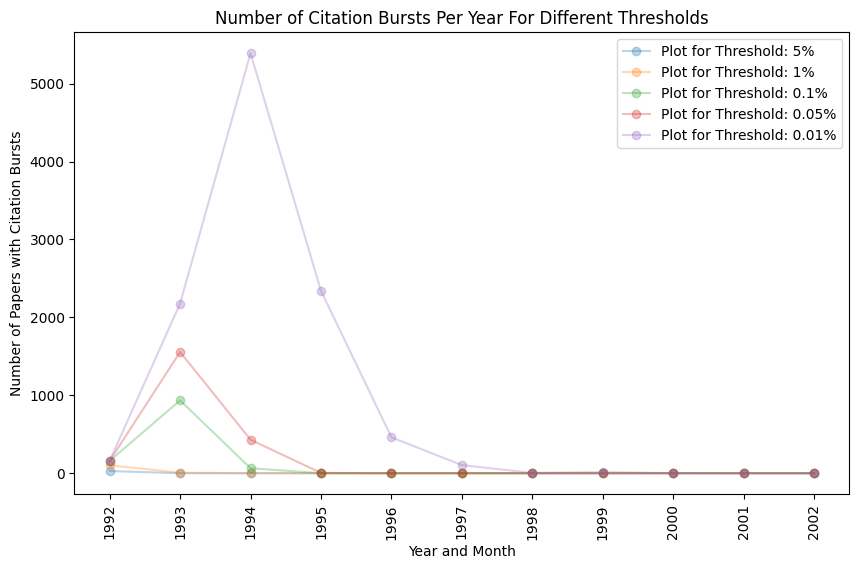

In [52]:
def plot_citation_bursts(G_array, threshold_percentage):
    bursts_array = identify_citation_bursts(G_array, threshold_percentage)
    y_bursts = np.zeros(len(x_years))
    for  ele in bursts_array:
        index = int(ele[1]/12)
        y_bursts[index]+=1
    label = f"Plot for Threshold: {threshold_percentage}%"
    plt.plot(x_years, y_bursts, marker="o", alpha=0.3, label=label)



plt.figure(figsize=(10, 6))

plot_citation_bursts(G_array, 5)
plot_citation_bursts(G_array, 1)
plot_citation_bursts(G_array, 0.1)
plot_citation_bursts(G_array, 0.05)
plot_citation_bursts(G_array, 0.01)

plt.xlabel("Year and Month")
plt.ylabel('Number of Papers with Citation Bursts')
plt.title("Number of Citation Bursts Per Year For Different Thresholds")
plt.xticks(x_years, x_years, rotation=90)
plt.legend(loc="upper right")  
plt.savefig("images/task1/property5.png")
plt.show()


### Property 6 - Diameter of the Graph

Graph 0 has diameter: 0
Graph 1 has diameter: 0
Graph 2 has diameter: 2
Graph 3 has diameter: 3
Graph 4 has diameter: 3
Graph 5 has diameter: 3
Graph 6 has diameter: 7


Graph 7 has diameter: 26
Graph 8 has diameter: 26
Graph 9 has diameter: 27
Graph 10 has diameter: 39
11


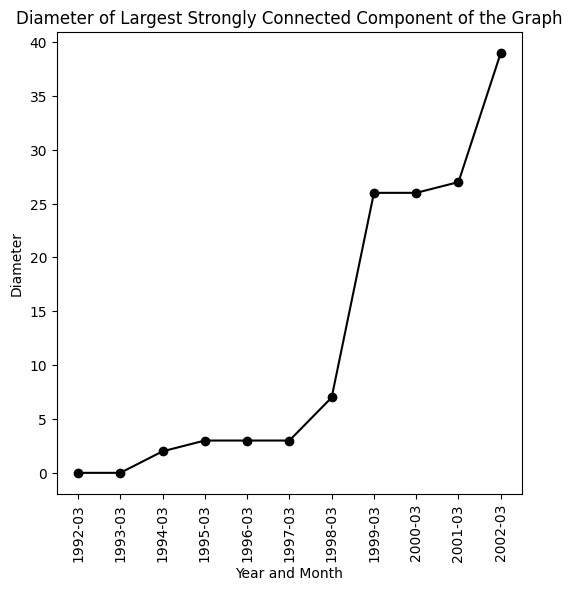

In [53]:
def find_largest_diameter(graph):
    # Find strongly connected components
    connected_components = list(nx.strongly_connected_components(graph))
    if not connected_components:
        print("No connected components found.")
        return 0

    # Find the largest connected component
    largest_component_nodes = max(connected_components, key=len)
    largest_component = graph.subgraph(largest_component_nodes)

    # Calculate the diameter of the largest connected component
    diameter = nx.diameter(largest_component)
    return diameter

# The calculation of diameter
diameter_array = []
for i, G in enumerate(G_array_yearly):
    diameter = find_largest_diameter(G)
    diameter_array.append(diameter)
    print(f"Graph {i} has diameter:", diameter)

print(len(G_array_yearly))
plt.figure(figsize=(6, 6))

plt.plot(x_time[::12], diameter_array, marker="o", color="black")
plt.xlabel("Year and Month")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
# plt.xticks(rotation=90)
plt.ylabel("Diameter")
plt.title("Diameter of Largest Strongly Connected Component of the Graph")
plt.savefig("images/task1/property6.png")
plt.show()


### Property 7 - Effective Diameter of the Graph

In [35]:
def calculate_effective_diameter(graph, alpha=0.9):
    graph = graph.to_undirected()
    all_shortest_paths = []
    for source in graph.nodes:
        paths = nx.shortest_path_length(graph, source=source)
        all_shortest_paths.extend(paths.values())

    all_shortest_paths.sort()
    index = int(len(all_shortest_paths)*alpha)
    return all_shortest_paths[index]

arr = []
for i, G in enumerate(G_array_yearly):
    if i==7:
        break 
    effective_diameter = calculate_effective_diameter(G, alpha=0.9)
    print(f"Graph {i}: ", effective_diameter)
    arr.append(effective_diameter)

Graph 0:  0
Graph 1:  9


Graph 2:  11
Graph 3:  8
Graph 4:  7
Graph 5:  7
Graph 6:  6


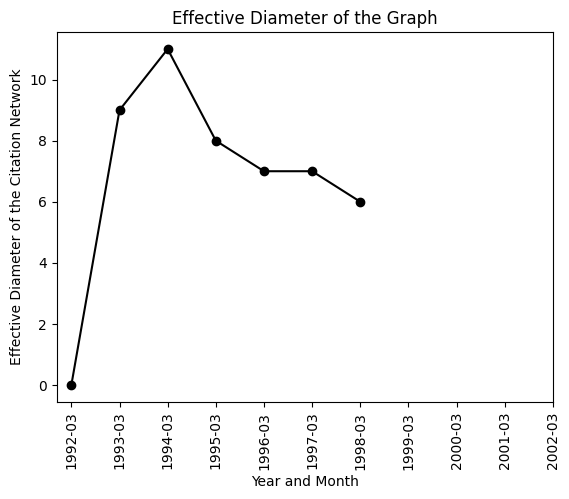

In [55]:

plt.plot(x_time[:80:12], arr, marker="o", color="black")
plt.xlabel("Year and Month")
plt.xticks(every_12th_time, every_12th_time, rotation=90)
plt.ylabel("Effective Diameter of the Citation Network")
plt.title("Effective Diameter of the Graph")
# plt.show()
plt.savefig("images/task1/property7.png")

### Property 8 - Centrality of Nodes

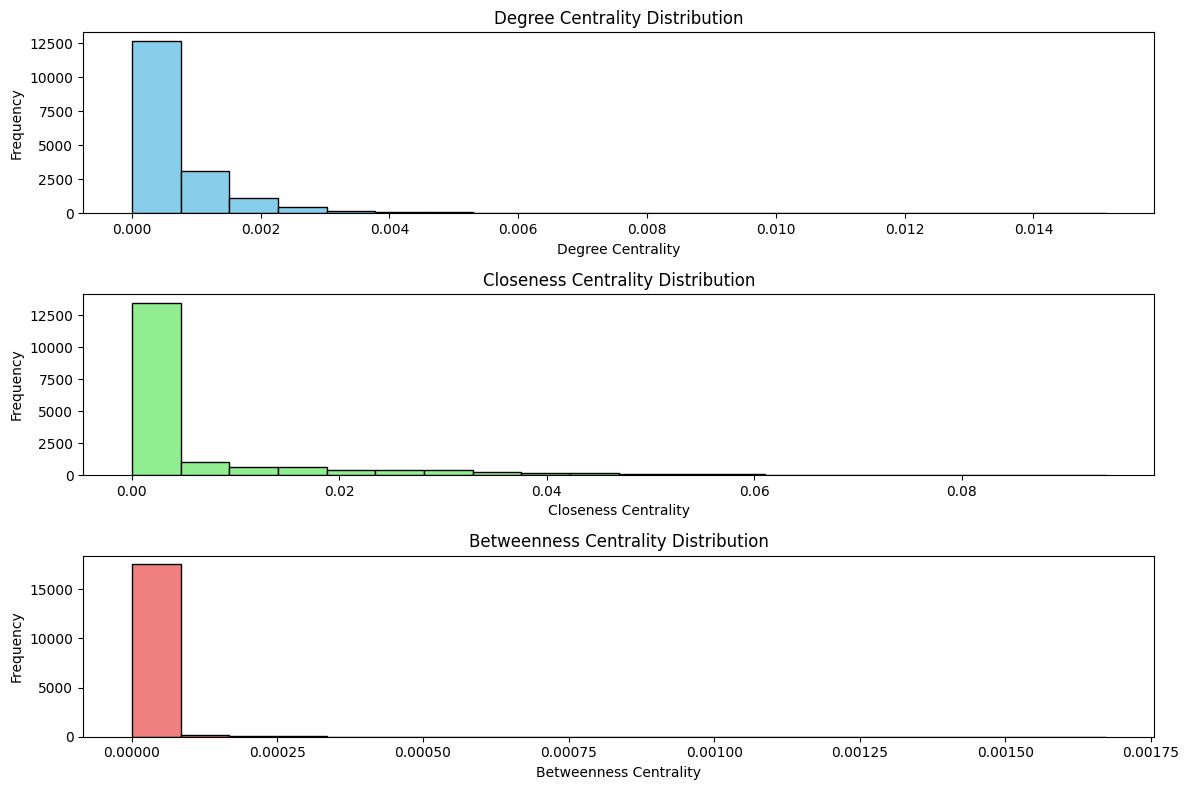

Average Degree Centrality: 0.0006621431519835222
Average Betweenness Centrality: 6.8156020190827986e-06
Average Closeness Centrality: 0.005523464833517492


In [54]:
import networkx as nx
import matplotlib.pyplot as plt

def calculate_and_plot_centrality(G):
    # Calculate centrality measures
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    # Compute average values
    avg_degree = sum(degree_centrality.values()) / len(degree_centrality)
    avg_betweenness = sum(betweenness_centrality.values()) / len(betweenness_centrality)
    avg_closeness = sum(closeness_centrality.values()) / len(closeness_centrality)

    # Plot frequency distribution
    plt.figure(figsize=(12, 8))

    # Degree Centrality
    plt.subplot(3, 1, 1)
    plt.hist(list(degree_centrality.values()), bins=20, color='skyblue', edgecolor='black')
    plt.title('Degree Centrality Distribution')
    plt.xlabel('Degree Centrality')
    plt.ylabel('Frequency')

    # Closeness Centrality
    plt.subplot(3, 1, 2)
    plt.hist(list(closeness_centrality.values()), bins=20, color='lightgreen', edgecolor='black')
    plt.title('Closeness Centrality Distribution')
    plt.xlabel('Closeness Centrality')
    plt.ylabel('Frequency')

    # Betweenness Centrality
    plt.subplot(3, 1, 3)
    plt.hist(list(betweenness_centrality.values()), bins=20, color='lightcoral', edgecolor='black')
    plt.title('Betweenness Centrality Distribution')
    plt.xlabel('Betweenness Centrality')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig("images/task1/property8.png")
    plt.show()

    return avg_degree, avg_betweenness, avg_closeness

# Calculate it for 1998 and not for the final graph as it takes too much time
average_degree_centrality, average_betweenness_centrality, average_closeness_centrality = calculate_and_plot_centrality(G_array[72])

print("Average Degree Centrality:", average_degree_centrality)
print("Average Betweenness Centrality:", average_betweenness_centrality)
print("Average Closeness Centrality:", average_closeness_centrality)

## Task 2

### Part 1 - Community Detection Algorithms

The following algorithms are used: 
1. DeepWalk
2. Node2Vec  
3. Graph Convolutional Network


#### Useful Functions

##### Function to Obtain Cluster Labels from Node Embeddings

In [56]:
def find_cluster_labels(node_embeddings, num_clusters = 5):

    # Extract node features for clustering
    X = np.array(list(node_embeddings.values()))

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=0)
    kmeans.fit(X)

    # Assign cluster labels to nodes
    return kmeans.labels_

##### Function to Visualize the Clusters

In [90]:
def plot_community_2d(cluster_labels, node_embeddings, method, num_clusters=5):
    node_cluster_mapping = dict(zip(G.nodes, cluster_labels))

    sampled_nodes = G.nodes()
    # Extract embeddings and labels for sampled nodes
    sampled_embeddings = [node_embeddings[str(node)] for node in sampled_nodes]
    sampled_embeddings = np.array(sampled_embeddings)
    sampled_cluster_labels = [node_cluster_mapping[node] for node in sampled_nodes]

    # Use t-SNE for dimensionality reduction
    tsne = TSNE(n_components=2) #, random_state=42)
    node_embeddings_2d = tsne.fit_transform(sampled_embeddings)

    # Plot the sampled node embeddings with colors based on clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=sampled_cluster_labels, cmap='viridis', alpha=0.3, marker=".")

    # Add a legend
    legend_labels = [f'Cluster {i}' for i in range(num_clusters)]
    plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels, title='Clusters')

    # Annotate points with node labels (optional)
    # for i, node in enumerate(sampled_nodes):
    #     plt.annotate(str(node), (node_embeddings_2d[i, 0], node_embeddings_2d[i, 1]))

    plt.title(f't-SNE Visualization of Sampled Node Embeddings with Clusters using {method}')
    plt.savefig(f"images/task2/part1/{method.lower()}")
    plt.show()

##### Function to Preprocess Graph Data for GCN

In [33]:
def preprocess_graph(G):
    # map[node] = index
    node_to_index = {node: index for index, node in enumerate(G.nodes)}
    # Convert edges to integer indices and convert to a torch tensor
    edges_index = [(node_to_index[src], node_to_index[dst]) for src, dst in G.edges]
    edge_index = torch.tensor(edges_index, dtype=torch.long).t().contiguous()
    # print(edges_index)

    # Node features are all the same
    x = torch.ones(len(G.nodes), 1)
    return x, edge_index

#### Method 1 - DeepWalk

##### Create a List of Random Walks to train the model on 

In [60]:
# TAKES 2 MINUTES TO RUN
def random_walk(start, length):
    walk = [str(start)]

    for i in range(length):
        neighbours = [node for node in G.neighbors(start)]
        if not neighbours:
            break
        next_node = np.random.choice(neighbours, 1)[0]
        walk.append(str(next_node))
        start = next_node

    return walk

walks = []
for node in G.nodes:
    # 80 random walks of length 100 for every node
    for _ in range(80):
        walks.append(random_walk(node, 100))

##### Train the Deepwalk Model and obtain the Node Embeddings

In [62]:
# TAKES 5 MINUTES TO RUN
model_deepwalk = Word2Vec(walks,
                 hs=1,
                 sg=1,
                 vector_size=100,
                 window=10,
                 workers=1,
                 seed=1)

print(f"shape of embedding matrix: {model_deepwalk.wv.vectors.shape}")

# Retrieve node embeddings
node_embeddings_deepwalk = {str(node): model_deepwalk.wv[str(node)] for node in G.nodes}

shape of embedding matrix: (37556, 100)


##### Perform K-means clustering on the Node Embeddings

In [63]:
num_clusters = 5
cluster_labels_deepwalk = find_cluster_labels(node_embeddings_deepwalk)

# # Print the cluster assignments for each node
# for node, cluster_label in node_cluster_mapping.items():
#     print(f"Node {node} belongs to Cluster {cluster_label}")

##### Visualize the communities

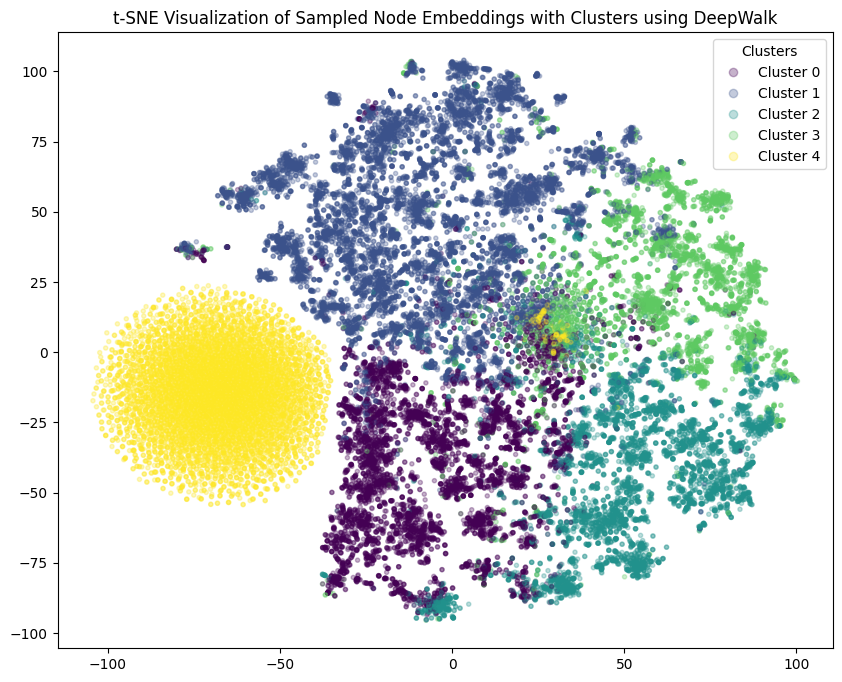

In [64]:
plot_community_2d(cluster_labels_deepwalk, node_embeddings_deepwalk, "DeepWalk")

#### Method 2 - Node2Vec

##### Train the Node2Vec model and obtain the Node Embeddings

In [65]:
# TAKES 10 MINUTES
G = G_array[-1]
model_node2vec = Node2Vec(G, dimensions=100, walk_length=100, num_walks=80, workers=1, seed=0)
model_node2vec = model_node2vec.fit(window=10, min_count=1, batch_words=4)

# Retrieve node embeddings
node_embeddings_node2vec = {str(node): model_node2vec.wv[str(node)] for node in G.nodes}

Computing transition probabilities:  25%|██▌       | 9552/37686 [00:00<00:01, 16808.37it/s]

Generating walks (CPU: 1): 100%|██████████| 80/80 [00:42<00:00,  1.87it/s]


##### Perform K-means clustering on the Node Embeddings

In [66]:
cluster_labels_node2vec = find_cluster_labels(node_embeddings_node2vec)

##### Visualize the Communities

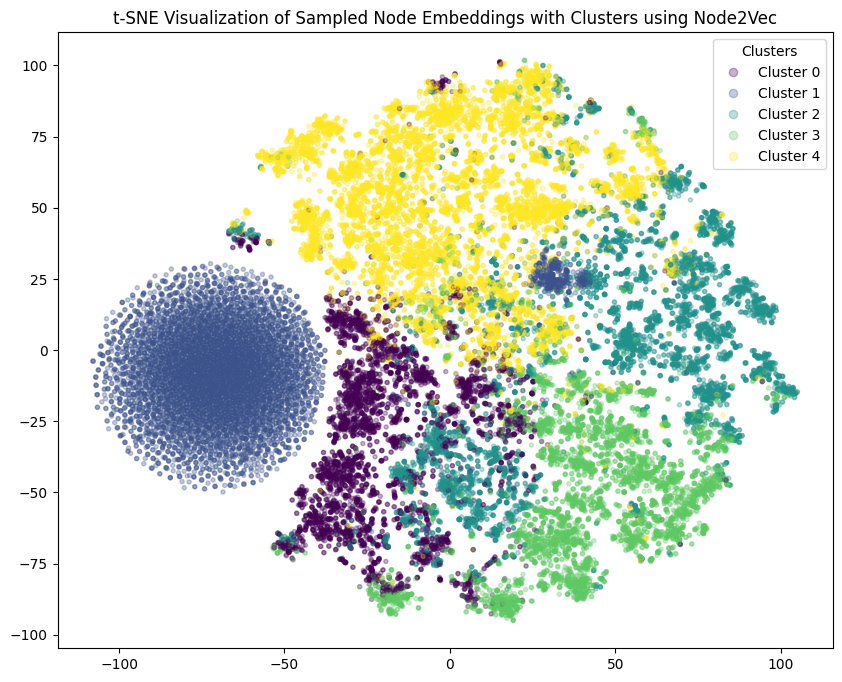

In [67]:
plot_community_2d(cluster_labels_node2vec, node_embeddings_node2vec, "Node2Vec")

#### Method 3 - Graph Convolutional Network

##### Create the GCN Model

In [69]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return F.log_softmax(h, dim=1)

##### Preprocess the Data and Obtain the Node Embeddings

In [70]:
G = G_array[-1]

x, edge_index = preprocess_graph(G)

dim_h = 100

model_gcn = GCN(1, dim_h, 10)
embeddings_array = model_gcn(x, edge_index).detach().numpy()

node_embeddings_gcn = {str(key):value for key, value in zip(G.nodes, embeddings_array)}

##### Perform K Means Clustering on the Node Embeddings

In [71]:
cluster_labels_gcn = find_cluster_labels(node_embeddings_gcn)

##### Visualize the Communities

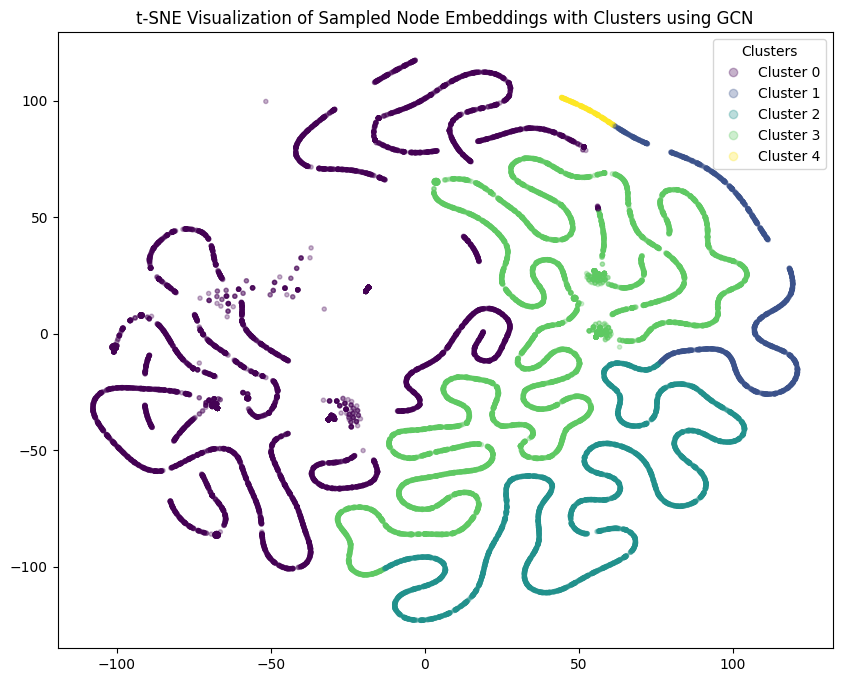

In [91]:
plot_community_2d(cluster_labels_gcn, node_embeddings_gcn, "GCN")

### Part 2 - Analyzing the Communities

#### Useful Functions

In [73]:
def calculate_modularity_conductance_coverage(G, node_embeddings, cluster_labels):
    # Convert cluster_labels to a NumPy array
    cluster_labels = np.array(cluster_labels)

    # Get unique cluster labels
    unique_clusters = np.unique(cluster_labels)

    # Initialize variables for modularity, conductance, and coverage
    modularity = 0.0
    conductance = 0.0
    coverage = 0.0

    # Loop through each unique cluster
    for cluster in unique_clusters:
        # Get the indices of nodes in the current cluster
        cluster_indices = np.where(cluster_labels == cluster)[0]
        graph_nodes = list(G.nodes)
        
        # Extract node embeddings for nodes in the current cluster
        cluster_embeddings = np.array([node_embeddings[str(graph_nodes[i])] for i in cluster_indices])

        # Calculate pairwise cosine similarity between node embeddings
        similarity_matrix = cosine_similarity(cluster_embeddings)

        # Calculate modularity contribution for the current cluster
        modularity += np.sum(similarity_matrix) / len(cluster_indices)

        # Calculate conductance for the current cluster
        conductance += np.sum(np.sum(similarity_matrix, axis=0) / np.sum(similarity_matrix)) / len(cluster_indices)

        # Update coverage
        coverage += len(cluster_indices)

    # Normalize modularity, conductance, and coverage
    modularity /= len(node_embeddings)
    conductance /= len(unique_clusters)
    coverage /= len(node_embeddings)

    return modularity, conductance, coverage

def get_cluster_sizes(cluster_labels):
    cluster_sizes = Counter(cluster_labels)
    cluster_sizes = list(cluster_sizes.values())
    cluster_sizes.sort(reverse=True)
    return cluster_sizes

def plot_cluster_sizes(cluster_labels, method, show=1):
    cluster_sizes = Counter(cluster_labels)
    cluster_sizes = list(cluster_sizes.values())
    cluster_sizes.sort(reverse=True)
    plt.bar(list(range(1, len(cluster_sizes)+1)), cluster_sizes, align='center')
    plt.xlabel('Cluster Label')
    plt.ylabel('Cluster Size')
    plt.title('Cluster Sizes')
    if show == 0:
        return
    plt.savefig(f"images/task2/part2/{method.lower()}")
    plt.show()

#### Method 1 - DeepWalk

##### Modularity, Conductance and Coverage of the Communities

In [74]:
modularity, conductance, coverage = calculate_modularity_conductance_coverage(G, node_embeddings_deepwalk, cluster_labels_deepwalk)
print("Modularity:", modularity)
print("Conductance:", conductance)
print("Coverage:", coverage)

Modularity: 0.1841856574208
Conductance: 0.00014489196450469705
Coverage: 1.0


##### Plot the Cluster Sizes

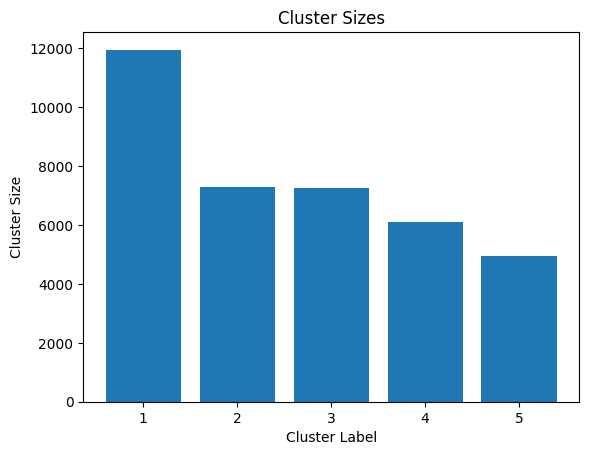

In [75]:
plot_cluster_sizes(cluster_labels_deepwalk, "DeepWalk")

##### 

#### Method 2 - Node2Vec

##### Modularity, Conductance and Coverage of the Communities

In [76]:
modularity, conductance, coverage = calculate_modularity_conductance_coverage(G, node_embeddings_node2vec, cluster_labels_node2vec)
print("Modularity:", modularity)
print("Conductance:", conductance)
print("Coverage:", coverage)

Modularity: 0.34309590457417205
Conductance: 0.0001391663822914578
Coverage: 1.0


##### Plot the Cluster Sizes

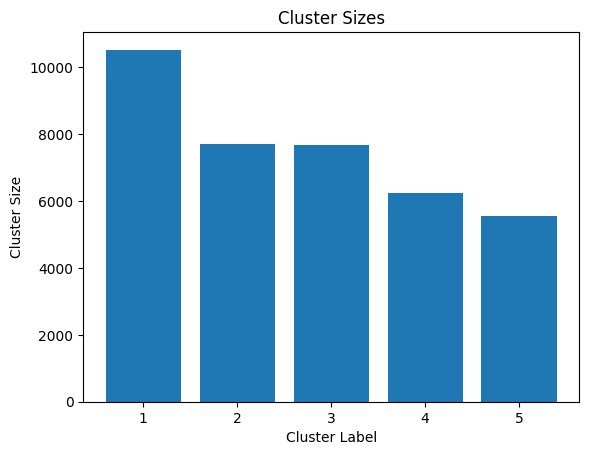

In [77]:
plot_cluster_sizes(cluster_labels_node2vec, "Node2Vec")

#### Method 3 - Graph Convolutional Network

##### Modularity, Conductance and Coverage of the Communities

In [78]:
modularity, conductance, coverage = calculate_modularity_conductance_coverage(G, node_embeddings_gcn, cluster_labels_gcn)
print("Modularity:", modularity)
print("Conductance:", conductance)
print("Coverage:", coverage)

Modularity: 0.9999570486560947
Conductance: 0.0012602133464637648
Coverage: 1.0


##### Plot the Cluster Sizes

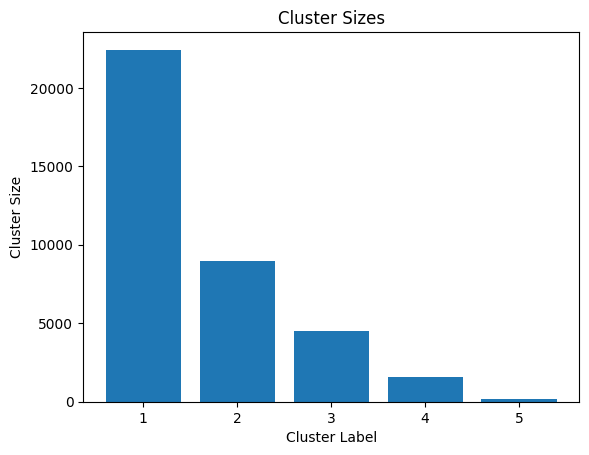

In [79]:
plot_cluster_sizes(cluster_labels_gcn, "GCN")

#### Further Analysis Using GCN and Varying Number of Clusters

We use GCN to experiment with the number of clusters as:
-  the GCN Model runs the fastest.
- It also gives the best results among the three models.
  
We can try to evaluate if the heterogenity in the sizes of the clusters stays similar across different number of clusters.

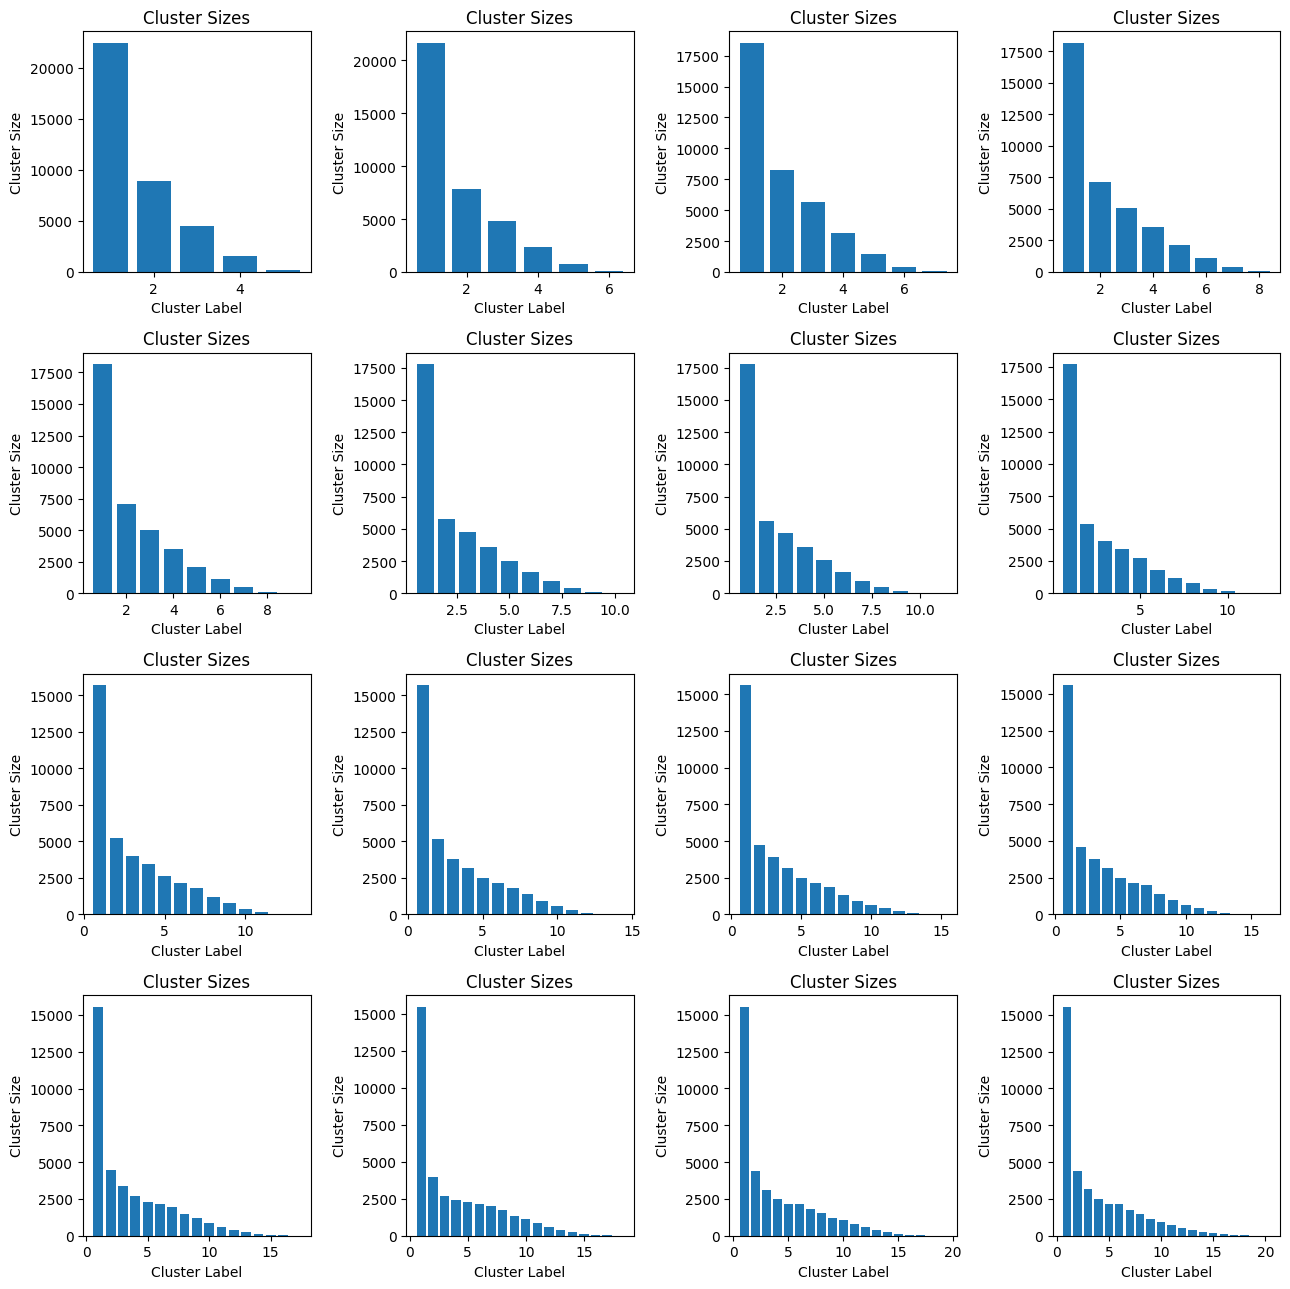

In [92]:
plt.figure(figsize=(13, 13))
for num_clusters in list(range(5, 21)):
    plt.subplot(4, 4, num_clusters-4)
    cluster_labels_ = find_cluster_labels(node_embeddings_gcn, num_clusters=num_clusters)
    plot_cluster_sizes(cluster_labels_, "GCN", show=0)

plt.tight_layout()
plt.savefig("images/task2/part2/further_gcn_analysis.png")
plt.show()

### Part 3 - Temporal Community Detection

In [85]:
modularity_array = []
conductance_array = []

jaccard_similarity_array = []
adjusted_rand_index_array = []
normalized_mutual_info_array = []
cluster_sizes_array = []

# used for calculating stability metrics
previous_cluster_labels_gcn = []

for G in G_array_yearly[1:]:
    # preprocess data
    x, edge_index = preprocess_graph(G)
    # feed x, edge_index into model
    embeddings_array = model_gcn(x, edge_index).detach().numpy()
    # obtain node embeddings
    node_embeddings_gcn = {str(key):value for key, value in zip(G.nodes, embeddings_array)}
    # find cluster labels using k means
    cluster_labels_gcn = find_cluster_labels(node_embeddings_gcn)

    cluster_sizes = get_cluster_sizes(cluster_labels_gcn)
    cluster_sizes_array.append(cluster_sizes)
    # obtain modularity, conductance and coverage
    modularity, conductance, _ = calculate_modularity_conductance_coverage(G, node_embeddings_gcn, cluster_labels_gcn)
    # append them to modularity, conductance arrays
    modularity_array.append(modularity)
    conductance_array.append(conductance)

    # # calculate the stability metrics - jaccard, adjusted rank index, normalized mutual information
    # if len(previous_cluster_labels_gcn):
    #     print("SHAPES ARE: ")
    #     print(cluster_labels_gcn.shape)
    #     print(previous_cluster_labels_gcn.shape)
    #     jaccard_similarity = jaccard_score(cluster_labels_gcn, previous_cluster_labels_gcn, average=None)
    #     adjusted_rand_index = adjusted_rand_score(cluster_labels_gcn, previous_cluster_labels_gcn)
    #     normalized_mutual_info = normalized_mutual_info_score(cluster_labels_gcn, previous_cluster_labels_gcn)
    #     # append to arrays
    #     jaccard_similarity_array.append(jaccard_similarity)
    #     adjusted_rand_index_array.append(adjusted_rand_index)
    #     normalized_mutual_info_array.append(normalized_mutual_info)

    # append the size of the ith community to the 2d array
    
    # find the centrality measures 
    previous_cluster_labels_gcn = cluster_labels_gcn


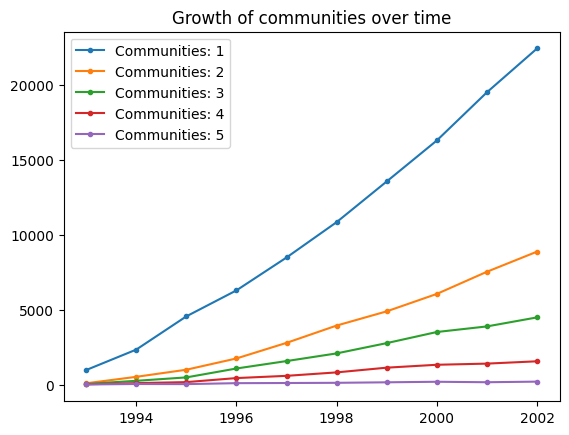

In [94]:

def plot_community_growth(cluster_sizes_array):
    n = len(cluster_sizes_array[0])
    for cluster in range(n):
        plt.plot(x_years[1:], [row[cluster] for row in cluster_sizes_array], label=f"Communities: {cluster + 1}", marker=".")
    plt.legend()
    plt.title("Growth of communities over time")
    plt.savefig("images/task2/part3/temporal_community_size.png")
    plt.show()

plot_community_growth(cluster_sizes_array)

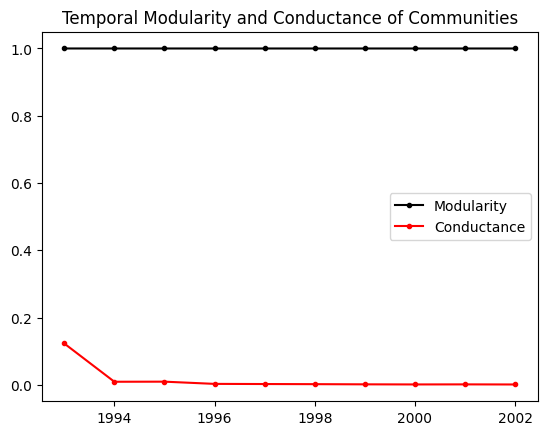

In [93]:
def plot_modularity_and_conductance(modularity_array, conductance_array):
    plt.plot(x_years[1:], modularity_array, label="Modularity", color="black", marker=".")
    plt.plot(x_years[1:], conductance_array, label="Conductance", color="red", marker=".")
    plt.legend()
    plt.title("Temporal Modularity and Conductance of Communities")
    plt.savefig("images/task2/part3/temporal_modularity_and_conductance.png")
    plt.show()

plot_modularity_and_conductance(modularity_array, conductance_array)

## Task 3

### Link Prediction Algorithms
The following algorithms have been used for link prediction:  
- Node2Vec
- Graph Convolutional Network

#### Method 1 - 

##### Create the GCN Model

In [51]:
class GCN(torch.nn.Module):
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)

    def forward(self, x, edge_index):
        h = self.gcn1(x, edge_index)
        h = torch.relu(h)
        h = self.gcn2(h, edge_index)
        return torch.relu(h)

##### Preprocess Data

In [52]:
time_index = 60
G = G_array[time_index].copy()
G_next = G_array[time_index+5].copy()

old_nodes = list(G.nodes)
all_nodes = list(G_next.nodes)

old_edges = list(G.edges)
all_edges = list(G_next.edges)

new_nodes = list(G_next.nodes)[len(G.nodes):]
new_edges = list(G_next.edges)[len(G.edges):]


print(new_nodes)
print(f"number of nodes = {len(G.nodes)}")
G.add_nodes_from(new_nodes) # Graph without new edges created
print(f"number of nodes = {len(G.nodes)}")

def generate_data(G, new_edges):
    all_nodes = set(G.nodes)
    all_node_pairs = list(combinations(all_nodes, 2))

    print(f"number of nodes = {len(G.nodes)}")
    print(f"len(all_nodes) = {len(all_nodes)}")

    positive_data = [(u, v, 1) for (u, v) in new_edges]
    negative_data = []
    for (u,v) in all_node_pairs:
        if u!=v and not G.has_edge(u, v) and (u, v) not in new_edges:
            negative_data.append((u, v, 0))
        if len(negative_data)==len(positive_data):
            break
    # negative_data = [(u, v, 0) for (u, v) in all_node_pairs if u != v and not G.has_edge(u, v) and (u, v) not in new_edges][:len(positive_data)]

    print(f"number of negative data = {len(negative_data)}")
    print(f"number of positive data = {len(positive_data)}")

    data = negative_data + positive_data
    random.shuffle(data)
    return data

data = generate_data(G, new_edges)
x, edge_index = preprocess_graph(G)


[9703208, 119703001, 9703209, 9703210, 9703211, 9703212, 9703213, 9703214, 9703215, 9703216, 9703217, 9703218, 9703219, 9703221, 9703222, 119703002, 119703018, 119703004, 9703220, 9703223, 9703224, 9703225, 9703226, 9703227, 9703228, 9703229, 9703230, 9703231, 9703233, 9703234, 9703235, 9703232, 9703236, 9703237, 9703238, 9703239, 9703240, 9703241, 9703242, 9703243, 9703244, 9703245, 9703246, 9703247, 9703248, 119703009, 119703010, 9703249, 9703250, 9703251, 9703252, 9703253, 9703254, 9703255, 9703256, 9703257, 9703258, 9703259, 119703011, 119703013, 119703015, 9703260, 9703261, 9703262, 9703263, 9703264, 9703265, 9703266, 9703267, 9703268, 9703269, 9703270, 9703271, 9703272, 9703273, 9703274, 119703044, 9703275, 9703276, 9703277, 9703278, 9703279, 119703017, 9703280, 9703281, 9703282, 9703283, 9703284, 9703285, 9703286, 9703289, 9703290, 9703291, 9706311, 119703072, 9703287, 9703288, 9703292, 9703293, 9703294, 9703295, 9703296, 9703297, 9703298, 119703077, 119703022, 9703299, 9703300,

##### Train Model and Obtain Node Embeddings

In [53]:
dim_h = 100

model_gcn2= GCN(1, dim_h, 10)
embeddings_array = model_gcn2(x, edge_index).detach().numpy()

node_embeddings_gcn2= {key:value for key, value in zip(G.nodes, embeddings_array)}

##### Obtain Edge Embeddings and Create Dataset

In [54]:
x = [(node_embeddings_gcn2[i]+node_embeddings_gcn2[j]) for i,j, _ in data]
y = [row[2] for row in data]
X_train, X_test, y_train, y_test = train_test_split(np.array(x), y, test_size = 0.2, )

##### Perform Logistic Regression

In [47]:
model_lr1 = LogisticRegression()

# Train the model
model_lr1.fit(X_train, y_train)

# Predict on the test set
y_pred = model_lr1.predict(X_test)

# Evaluate the performance
accuracy_gcn = accuracy_score(y_test, y_pred)
classification_report_result_gcn = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_gcn}")
print("Classification Report:\n", classification_report_result_gcn)

Accuracy: 0.6805597809552784
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.78      0.71      3259
           1       0.73      0.59      0.65      3315

    accuracy                           0.68      6574
   macro avg       0.69      0.68      0.68      6574
weighted avg       0.69      0.68      0.68      6574



#### Method 2 - Node2Vec

##### Get unconnected node pairs

In [55]:
time_index = 60
G = G_array[time_index].copy()
G_next = G_array[time_index+5].copy()

old_nodes = list(G.nodes)
all_nodes = list(G_next.nodes)

old_edges = list(G.edges)
all_edges = list(G_next.edges)

new_nodes = list(G_next.nodes)[len(G.nodes):]
new_edges = list(G_next.edges)[len(G.edges):]

G.add_nodes_from(new_nodes) # Graph without new edges created

data = generate_data(G, new_edges)

number of nodes = 15259
len(all_nodes) = 15259
number of negative data = 16433
number of positive data = 16433


##### Train Node2Vec on This New Graph

In [56]:
# Generate walks
node2vec = Node2Vec(G, dimensions=100, walk_length=15, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:04<00:00, 11.02it/s]


##### Obtain Edge Features

In [57]:
node_embeddings_node2vec2 = {str(node): n2w_model.wv[str(node)] for node in G.nodes}
x = [(node_embeddings_node2vec2[str(i)]+node_embeddings_node2vec2[str(j)]) for i,j, _ in data]


##### Split Edge Features into Train and Test Data

In [58]:
y = [row[2] for row in data]
X_train, X_test, y_train, y_test = train_test_split(np.array(x), y, test_size = 0.2, )

##### Perform Logistic Regression

In [97]:
model_lr2 = LogisticRegression()

# Train the model
model_lr2.fit(X_train, y_train)

# Predict on the test set
y_pred = model_lr2.predict(X_test)

# Evaluate the performance
accuracy_node2vec = accuracy_score(y_test, y_pred)
classification_report_result_node2vec = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy_node2vec}")
print("Classification Report:\n", classification_report_result_node2vec)

Accuracy: 0.8321501014198783
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.99      0.91     16278
           1       0.63      0.09      0.16      3442

    accuracy                           0.83     19720
   macro avg       0.73      0.54      0.54     19720
weighted avg       0.80      0.83      0.78     19720



### Comparing the Predictions

- The Accuracy of the Node2Vec Model is: `83%`
  
- The Accuracy of the GCN Model is: `68%`
- The Precision, Recall and F1-score of the Node2Vec model were consistently better than that of the GCN Model.